In [1]:
import numpy as np
import phate
from heatgeo.embedding import HeatGeo
import scprep
from scipy.spatial.distance import pdist, squareform
import demap


In [2]:
# data = np.load("/gpfs/gibbs/pi/krishnaswamy_smita/dl2282/dmae/data/swiss_roll_1.0_seed1.npz")
datas = [np.load(f"/gpfs/gibbs/pi/krishnaswamy_smita/dl2282/dmae/data/s_curve_noise0.1_seed{i}.npz") for i in range(1,4)]
# datas = [np.load(f"/gpfs/gibbs/pi/krishnaswamy_smita/dl2282/dmae/data/swiss_roll_noise1.0_seed{i}.npz") for i in range(1,4)]
# data = np.load("/gpfs/gibbs/pi/krishnaswamy_smita/dl2282/dmae/data/s_curve_noise0.1.npz")
# data = np.load("/gpfs/gibbs/pi/krishnaswamy_smita/dl2282/dmae/data/swiss_roll_noise0.1_seed1.npz")

In [3]:
# datas

In [4]:
x0 = datas[0]['data']
x1 = datas[1]['data']
x2 = datas[2]['data']
x1[:,1] = x1[:,1] + x0[:,1].max() - 0.5
x = np.r_[x0,x1]
x2[:,1] = x2[:,1] + x[:,1].max() - 0.5
x = np.r_[x,x2]

In [5]:
colors = np.r_[*[data['colors'] for data in datas]]

In [6]:
x0 = datas[0]['data_gt']
x1 = datas[1]['data_gt']
x2 = datas[2]['data_gt']
x1[:,1] = x1[:,1] + x0[:,1].max()
x_gt = np.r_[x0,x1]
x2[:,1] = x2[:,1] + x_gt[:,1].max()
x_gt = np.r_[x_gt,x2]

In [7]:
np.random.seed(42)
subset_idx = np.random.choice(len(x), size=3000, replace=False)
is_train = np.array([i in (subset_idx) for i in range(len(x))])

In [8]:
is_train.sum()

3000

In [9]:
# x = data['data']
# x_gt = data['data_gt']
# colors = data['colors']
# x[:,1] = x[:,1] * 3
# x_gt[:,1] = x_gt[:,1] * 3

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes3D: >

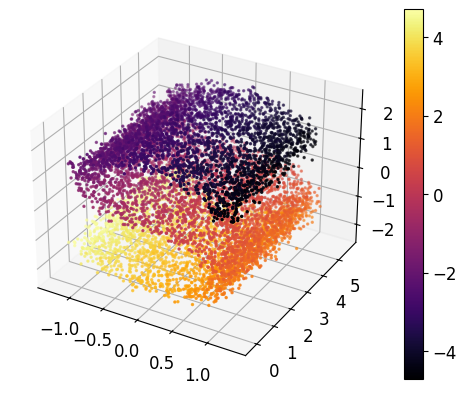

In [10]:
scprep.plot.scatter3d(x, c=colors)

In [11]:
phate_op = phate.PHATE(knn=30, t=100, random_state=3)
# phate_op = phate.PHATE()
x_phate = phate_op.fit_transform(x)

Calculating PHATE...
  Running PHATE on 9000 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.47 seconds.
    Calculating affinities...
    Calculated affinities in 0.14 seconds.
  Calculated graph and diffusion operator in 0.63 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.75 seconds.
    Calculating KMeans...
    Calculated KMeans in 11.18 seconds.
  Calculated landmark operator in 12.73 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.17 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.96 seconds.
Calculated PHATE in 20.52 seconds.


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: title={'center': 's-curve PHATE knn=30, t=100'}>

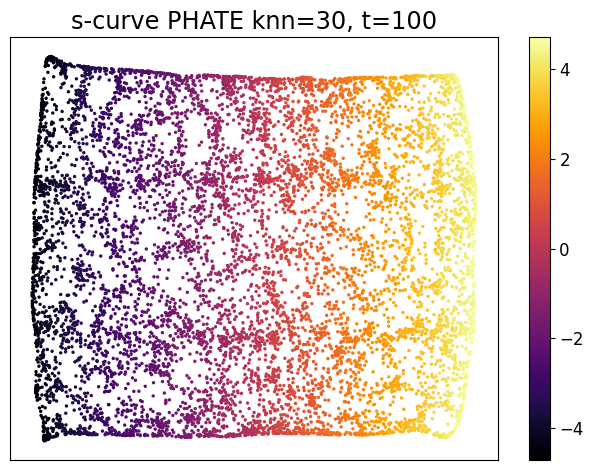

In [12]:
scprep.plot.scatter2d(x_phate, c=colors, ticks=False, title=f"s-curve PHATE knn=30, t=100")

In [13]:
x_gt.shape

(9000, 3)

In [14]:
# data_dict = {file: data[file] for file in data.files}
data_dict = dict(
    data=x,
    data_gt=x_gt,
    colors=colors,
    is_train=is_train,
)

In [15]:
data_dict['phate'] = x_phate
# diff_potential = phate_op.diff_potential[is_train]
diff_potential = phate_op.diff_potential
# dist_mat = np.zeros((x.shape[0], x.shape[0]))
phate_dist = squareform(pdist(diff_potential))
# dist_mat[is_train][:,is_train] = phate_dist # only storing the training ones to save time.
# data_dict['dist'] = dist_mat
data_dict['dist'] = phate_dist
np.savez("../data/scurve0.1_phate_flat.npz", **data_dict)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: title={'center': 'PHATE knn=30, t=100, DEMaP=0.961'}>

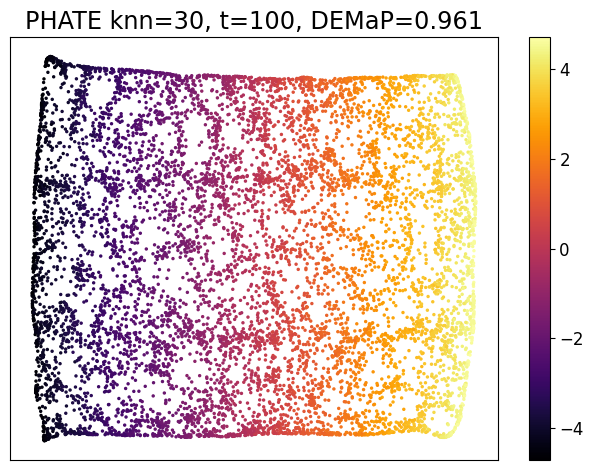

In [16]:
val = demap.DEMaP(x_gt[is_train], x_phate[is_train], knn=30)
val = np.round(val, 3)
scprep.plot.scatter2d(x_phate, c=colors, ticks=False, title=f"PHATE knn=30, t=100, DEMaP={val}")

In [17]:
x_gt.shape

(9000, 3)

In [18]:
import pickle
with open('../data/scurve0.1_phate_flat_phate_op.pkl', 'wb') as file:
    pickle.dump(phate_op, file)